In [15]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import matplotlib.pyplot as plt
plt.style.use('../benxi.mplstyle')
import matplotlib.cm as cm
import matplotlib.colors as colors
import corner
from matplotlib.patches import Ellipse
import cmasher as cmr

from scipy import interpolate
import os
from tqdm import tqdm
import scipy
import vaex
import pandas as pd
import numpy as np
import emcee
# add paraent path to sys.path to import modules
import sys
sys.path.append('../')
from dataload import CMDdata
from mcmc_mono_group import *
from train_mdn import *

In [21]:
mh_edges = np.array([-1., -0.6, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.5])
mh_mids = mh_edges[:-1] + 0.5*np.diff(mh_edges)
mh_mids = [np.round(_, 2) for _ in mh_mids]


device = torch.device(0)
n_train = 5000
n_star  = 10000

moh = 0.3
dataset = CMDdata(f"/nfsdata/users/jdli_ny/bf/train_1025_twin/cmd_moh_{moh}.npz", 
                  device=torch.device('cpu'), n_star=n_star, mode=None)


In [22]:
idx = 29
dataset[idx]

(tensor([[5.5228, 0.0465, 0.0728],
         [5.7417, 0.0465, 0.0728],
         [5.8786, 0.0465, 0.0728],
         ...,
         [5.9005, 0.0465, 0.0728],
         [4.7282, 0.0465, 0.0728],
         [4.9830, 0.0465, 0.0728]]),
 tensor([[0.9756],
         [1.0051],
         [1.1000],
         ...,
         [1.0772],
         [0.8184],
         [0.8229]]))

In [24]:
# n_star = 10000
n_input = 3
z = np.zeros((n_star, n_input))

z.T[0] = dataset[idx][0].T[0].detach().cpu().numpy()
obs = dataset[idx][1].detach().cpu().numpy()

model_mono = MDN(
    n_input=n_input, n_hidden=16, n_gaussians=2
    )

model_name =  f'/nfsdata/users/jdli_ny/bf/mdn_modl/dd/mdn_1025_h16_bt_{moh}.pt'

model_mono.load_state_dict(torch.load(model_name))

print(
    log_post(
    np.array([0.5, 0.5]), 
    torch.from_numpy(obs.astype("float32")), 
    torch.from_numpy(z.astype("float32")), model_mono)
    )

ndim, nwalkers = 2, 32
init = np.array([0.5, 0.5])
init = init + np.random.normal(0, 1e-3*init, (nwalkers, ndim))


model_peak = MDN(n_input=1, n_hidden=16, n_gaussians=2)
# moh = -0.9 if idx==0 else mh_mids[idx]

model_peak.load_state_dict(
    torch.load(
        f'/nfsdata/users/jdli_ny/bf/mdn_blueedge_v2/group_{moh}.pt')
    )


# run MCMC
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, 
    log_post_bound,
    args=(
        torch.from_numpy(obs.astype("float32")), 
        torch.from_numpy(z.astype("float32")),
        model_mono, 0.01
        ), 
)
# burn-in
# pos, _, _  = sampler.run_mcmc(init, 500, progress=True)
# sampler.reset()
# production run
sampler.run_mcmc(init, 3000, progress=True)
samples = sampler.get_chain(discard=500, flat=True)
print(np.median(samples, axis=0))

1855.0578355789185


  0%|                                                                                                      | 1/3000 [00:00<05:06,  9.78it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [02:44<00:00, 18.25it/s]

[0.03743668 0.06231627]


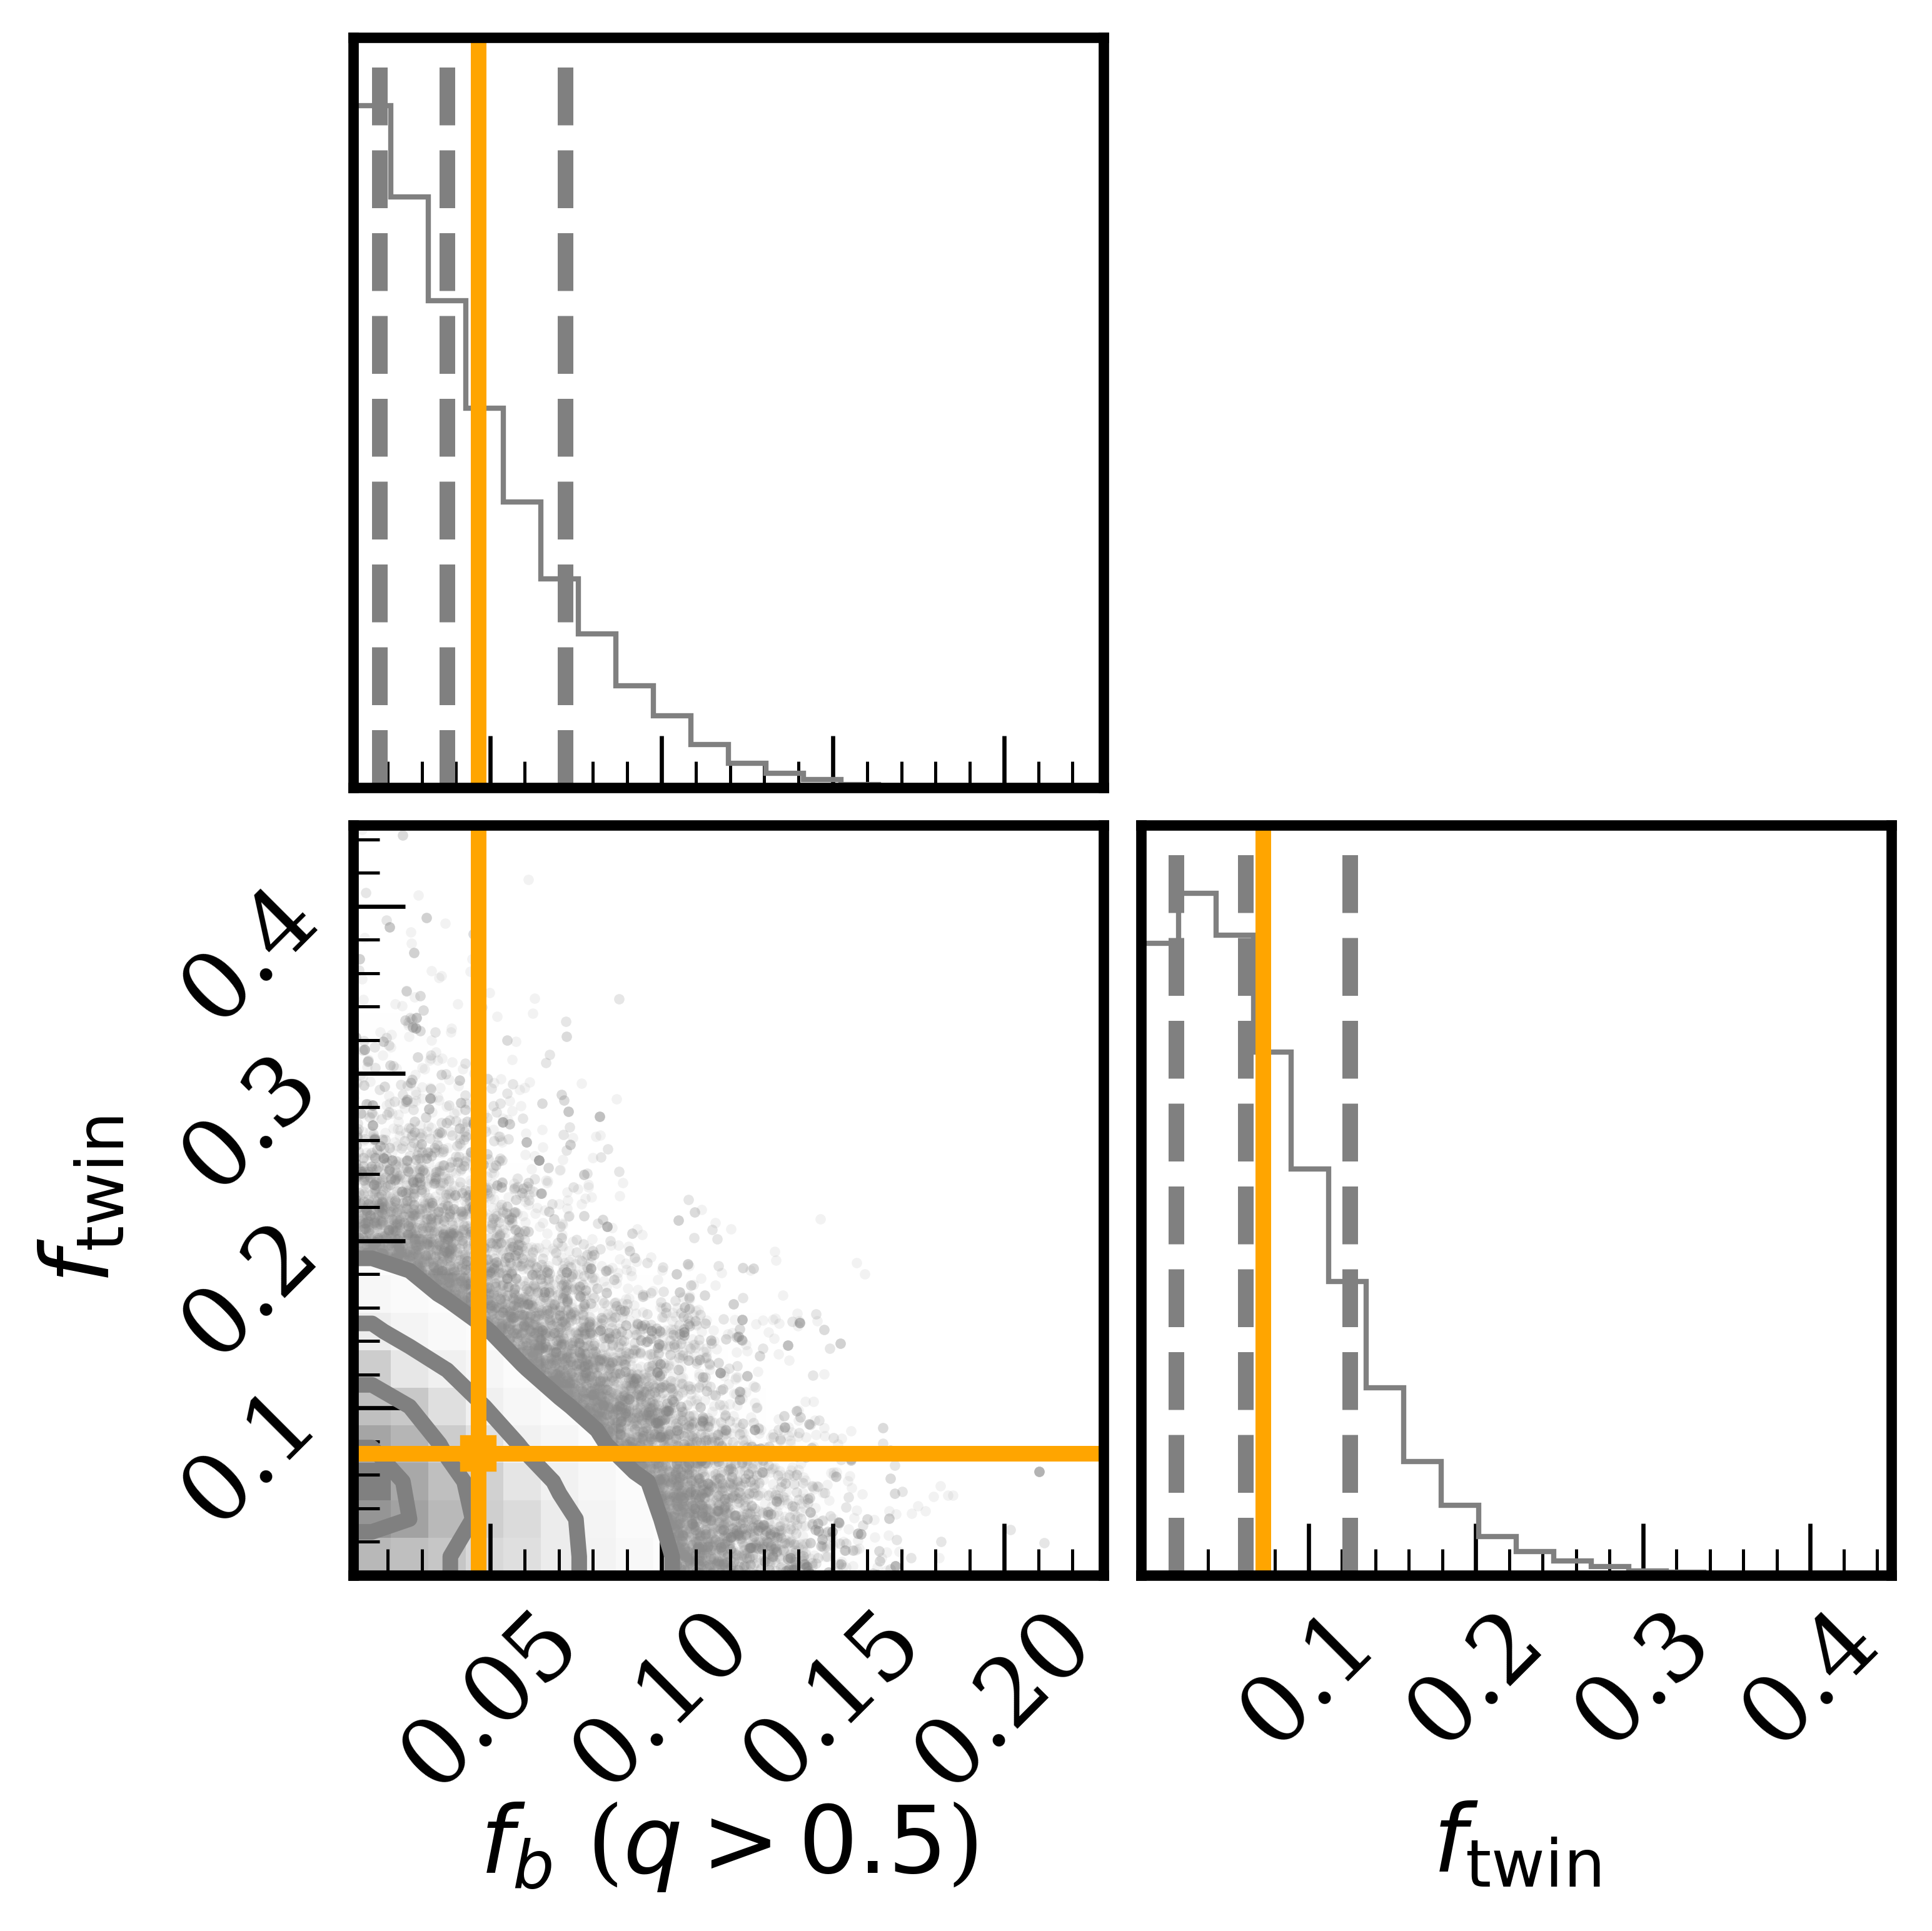

In [25]:
fig = corner.corner(
    samples,
    color="grey",
    labels=[r"$f_b$ ($q>0.5$)", r"$f_{\rm twin}$"], 
    # labels=[r"$f_b$", r"$\gamma$"],
    title_kwargs={"fontsize": 18}, 
    label_kwargs={"fontsize": 18},
    quantiles=[0.16, 0.50, 0.84],
    truths=dataset[idx][0][0,1:].cpu().numpy(),
    truth_color="orange",
)

In [32]:
dataset[idx][0].T[0].cpu().numpy() 

array([5.5228353, 5.7417173, 5.8786235, ..., 5.900484 , 4.728236 ,
       4.9830136], dtype=float32)

In [35]:
# plot the CMD
fig, ax = plt.subplots(figsize=(8, 8))
ax.hist2d(
        dataset[idx][1].cpu().numpy().T[0], dataset[idx][0].T[0].cpu().numpy(), 
        bins=100, norm=colors.LogNorm(vmin=1), cmap='cmr.cosmic');
    

ax.set_ylim([9., 4]);
ax.set_xlim([0.4, 2.5]);
ax.set_ylabel(r'$M_{G0}$') # label first column
ax.set_xlabel(r'(Bp$-$Rp)$_0$') # label last row
# aanotate fb and ftwin in the plot
ax.annotate(
    f'$f_b={np.median(samples, axis=0)[0]:.2f}$', 
    xy=(0.95, 0.9), xycoords='axes fraction', fontsize=18
)
ax.annotate(
    f'$ftin={np.median(samples, axis=0)[1]:.2f}$', 
    xy=(0.95, 0.9), xycoords='axes fraction', fontsize=18
)

Text(0.95, 0.9, '$ftin=0.06$')